In [7]:
import tensorflow as tf

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
# Load the dataset
import tensorflow as tf

train, test = tf.keras.datasets.mnist.load_data(path="mnist.npz")
train_x, train_y = train
test_x, test_y = test
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [10]:
# Add random noise to train_x and test_x
train_x_noisey = (train_x + 15* tf.random.normal(shape=train_x.shape)).numpy()
train_x_noisey.shape

(60000, 28, 28)

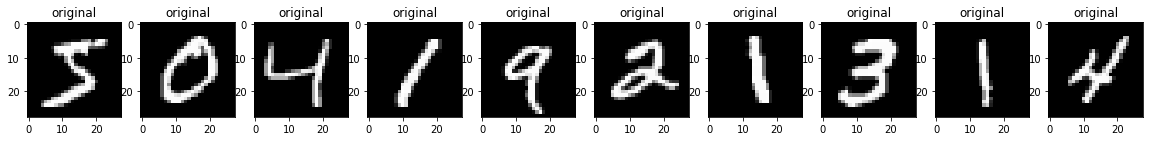

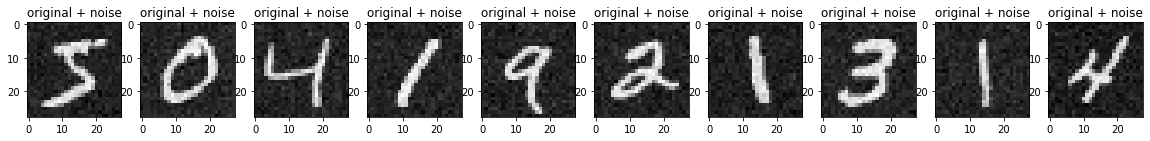

In [11]:
# Create function to plot original and noisey datasets
import matplotlib.pyplot as plt

def plot_original_and_noisey(original=train_x, noisey=train_x_noisey, n=10):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.title("original")
        plt.imshow(tf.squeeze(original[i]))
        plt.gray()
    plt.show()

    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(noisey[i]))
        plt.gray()
    plt.show()

# Plot original train_x and noisey test_x
plot_original_and_noisey()

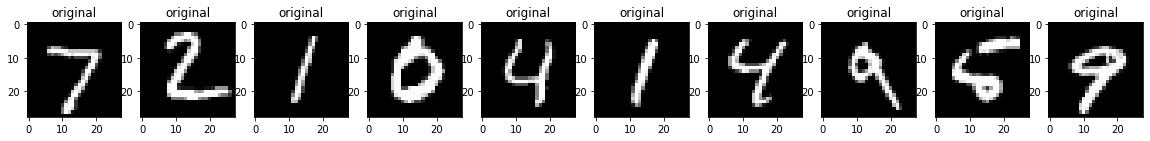

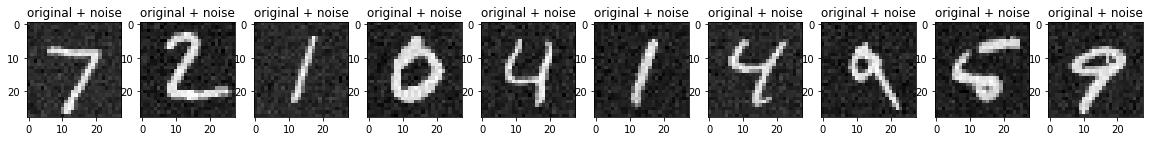

In [12]:
# Plot noisey test_x
test_x_noisey = (test_x + 15* tf.random.normal(shape=test_x.shape)).numpy()
plot_original_and_noisey(original=test_x, noisey=test_x_noisey)

In [14]:
# Split test into validation and test
from sklearn.model_selection import train_test_split

val_x_noisey, test_x_noisey, val_x, test_x = train_test_split(test_x_noisey, test_x, test_size=0.5)
val_x.shape, test_x.shape, val_x_noisey.shape, test_x_noisey.shape

((2500, 28, 28), (2500, 28, 28), (2500, 28, 28), (2500, 28, 28))

In [15]:
# Create checkpoint for model training
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='ImageDenoiser', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [16]:
# Make convolutional autoencoder for image denoising
from tensorflow.keras.layers import InputLayer, Conv2D, Conv2DTranspose, Reshape, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError

class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = Sequential([
          InputLayer(input_shape=(28, 28)),
          Reshape((28, 28, 1)),
          Lambda(lambda x: x / 255),
          Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = Sequential([
          Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          Conv2D(1, kernel_size=(3, 3), activation='relu', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())
autoencoder.fit(train_x_noisey, train_x, validation_data=(val_x_noisey, val_x), epochs=10, callbacks=[checkpoint])
autoencoder.summary()

Epoch 1/10
1875/1875 [==============================] - 14s 4ms/step - loss: 978.8194 - val_loss: 270.5746

Epoch 00001: val_loss improved from inf to 270.57462, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 228.1846 - val_loss: 194.5298

Epoch 00002: val_loss improved from 270.57462 to 194.52983, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 183.8623 - val_loss: 165.7235

Epoch 00003: val_loss improved from 194.52983 to 165.72354, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 157.2005 - val_loss: 143.3996

Epoch 00004: val_loss improved from 165.72354 to 143.39963, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\

In [17]:
# Train Longer
autoencoder.fit(train_x_noisey, train_x, validation_data=(val_x_noisey, val_x), epochs=10, callbacks=[checkpoint])

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 100.6964 - val_loss: 97.0486

Epoch 00001: val_loss improved from 99.80063 to 97.04862, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 98.6435 - val_loss: 96.4713

Epoch 00002: val_loss improved from 97.04862 to 96.47127, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 96.8766 - val_loss: 94.0850

Epoch 00003: val_loss improved from 96.47127 to 94.08501, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 95.3229 - val_loss: 92.7739

Epoch 00004: val_loss improved from 94.08501 to 92.77394, saving model to ImageDenoiser
INFO:tensorflow:Assets written to: ImageDenoiser\assets
Epo

In [18]:
# Describe the Encoder part
autoencoder.encoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Describe the Decoder part
autoencoder.decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Run the noisey test_x through the model
test_x_denoised = autoencoder(test_x_noisey).numpy()
test_x_denoised.shape

(2500, 28, 28, 1)

In [22]:
# Reshape (wouldn't be neccessary if layer was added in the model)
test_x_denoised = test_x_denoised.reshape((2500, 28, 28))
test_x_denoised.shape

(2500, 28, 28)

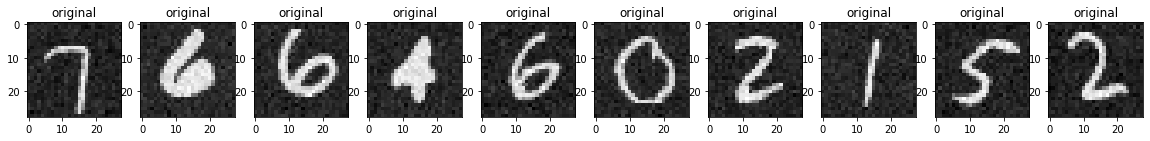

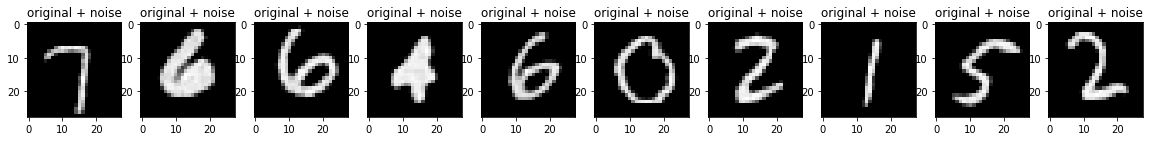

In [23]:
# Plot noisey test_x and cleaned test_x through the model
plot_original_and_noisey(original=test_x_noisey, noisey=test_x_denoised)